https://www.kaggle.com/code/mihirpaghdal/default-loan-predictor/input?select=Test+Data.csv
    
An organization wants to predict who possible defaulters are for the consumer loans product. They have data about historic customer behavior based on what they have observed. Hence when they acquire new customers they want to predict who is riskier and who is not.

* Non-Defaulter=0
* Defaulter=1

# Import Python Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import f_oneway

#https://github.com/parrt/dtreeviz/blob/master/notebooks/dtreeviz_sklearn_visualisations.ipynb
import dtreeviz
from yellowbrick.model_selection import FeatureImportances

import matplotlib.pyplot as plt
%matplotlib inline
import category_encoders as ce # Encode Categorical Variables

from ydata_profiling import ProfileReport
import missingno as msno

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.svm import SVC
from sklearn import svm
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import PassiveAggressiveClassifier

from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

# SMOTE
from imblearn.over_sampling import SMOTE

In [2]:
df = pd.read_csv('Loan Prediction Based on Customer Behavior.csv')

In [96]:
# pip install dtreeviz

In [97]:
# pip install yellowbrick

In [98]:
# pip install ydata-profiling

In [99]:
# pip install missingno

In [4]:
ProfileReport(df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [157]:
df.head()

Id   Income  Age  Experience Married/Single House_Ownership Car_Ownership  \
0   1  1303834   23           3         single          rented            no   
1   2  7574516   40          10         single          rented            no   
2   3  3991815   66           4        married          rented            no   
3   4  6256451   41           2         single          rented           yes   
4   5  5768871   47          11         single          rented            no   

            Profession                 CITY           STATE  CURRENT_JOB_YRS  \
0  Mechanical_engineer                 Rewa  Madhya_Pradesh                3   
1   Software_Developer             Parbhani     Maharashtra                9   
2     Technical_writer            Alappuzha          Kerala                4   
3   Software_Developer          Bhubaneswar          Odisha                2   
4        Civil_servant  Tiruchirappalli[10]      Tamil_Nadu                3   

   CURRENT_HOUSE_YRS  Risk_Flag  
0                 13          0  
1                 13          0  
2                 10          0  
3                 12          1  
4                 14          1

In [158]:
df.tail()

Id   Income  Age  Experience Married/Single House_Ownership  \
251995  251996  8154883   43          13         single          rented   
251996  251997  2843572   26          10         single          rented   
251997  251998  4522448   46           7         single          rented   
251998  251999  6507128   45           0         single          rented   
251999  252000  9070230   70          17         single          rented   

       Car_Ownership        Profession             CITY           STATE  \
251995            no           Surgeon          Kolkata     West_Bengal   
251996            no      Army_officer             Rewa  Madhya_Pradesh   
251997            no   Design_Engineer  Kalyan-Dombivli     Maharashtra   
251998            no  Graphic_Designer      Pondicherry      Puducherry   
251999            no      Statistician            Avadi      Tamil_Nadu   

        CURRENT_JOB_YRS  CURRENT_HOUSE_YRS  Risk_Flag  
251995                6                 11          0  
251996                6                 11          0  
251997                7                 12          0  
251998                0                 10          0  
251999                7                 11          0

In [159]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252000 entries, 0 to 251999
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Id                 252000 non-null  int64 
 1   Income             252000 non-null  int64 
 2   Age                252000 non-null  int64 
 3   Experience         252000 non-null  int64 
 4   Married/Single     252000 non-null  object
 5   House_Ownership    252000 non-null  object
 6   Car_Ownership      252000 non-null  object
 7   Profession         252000 non-null  object
 8   CITY               252000 non-null  object
 9   STATE              252000 non-null  object
 10  CURRENT_JOB_YRS    252000 non-null  int64 
 11  CURRENT_HOUSE_YRS  252000 non-null  int64 
 12  Risk_Flag          252000 non-null  int64 
dtypes: int64(7), object(6)
memory usage: 25.0+ MB


There are no missing values


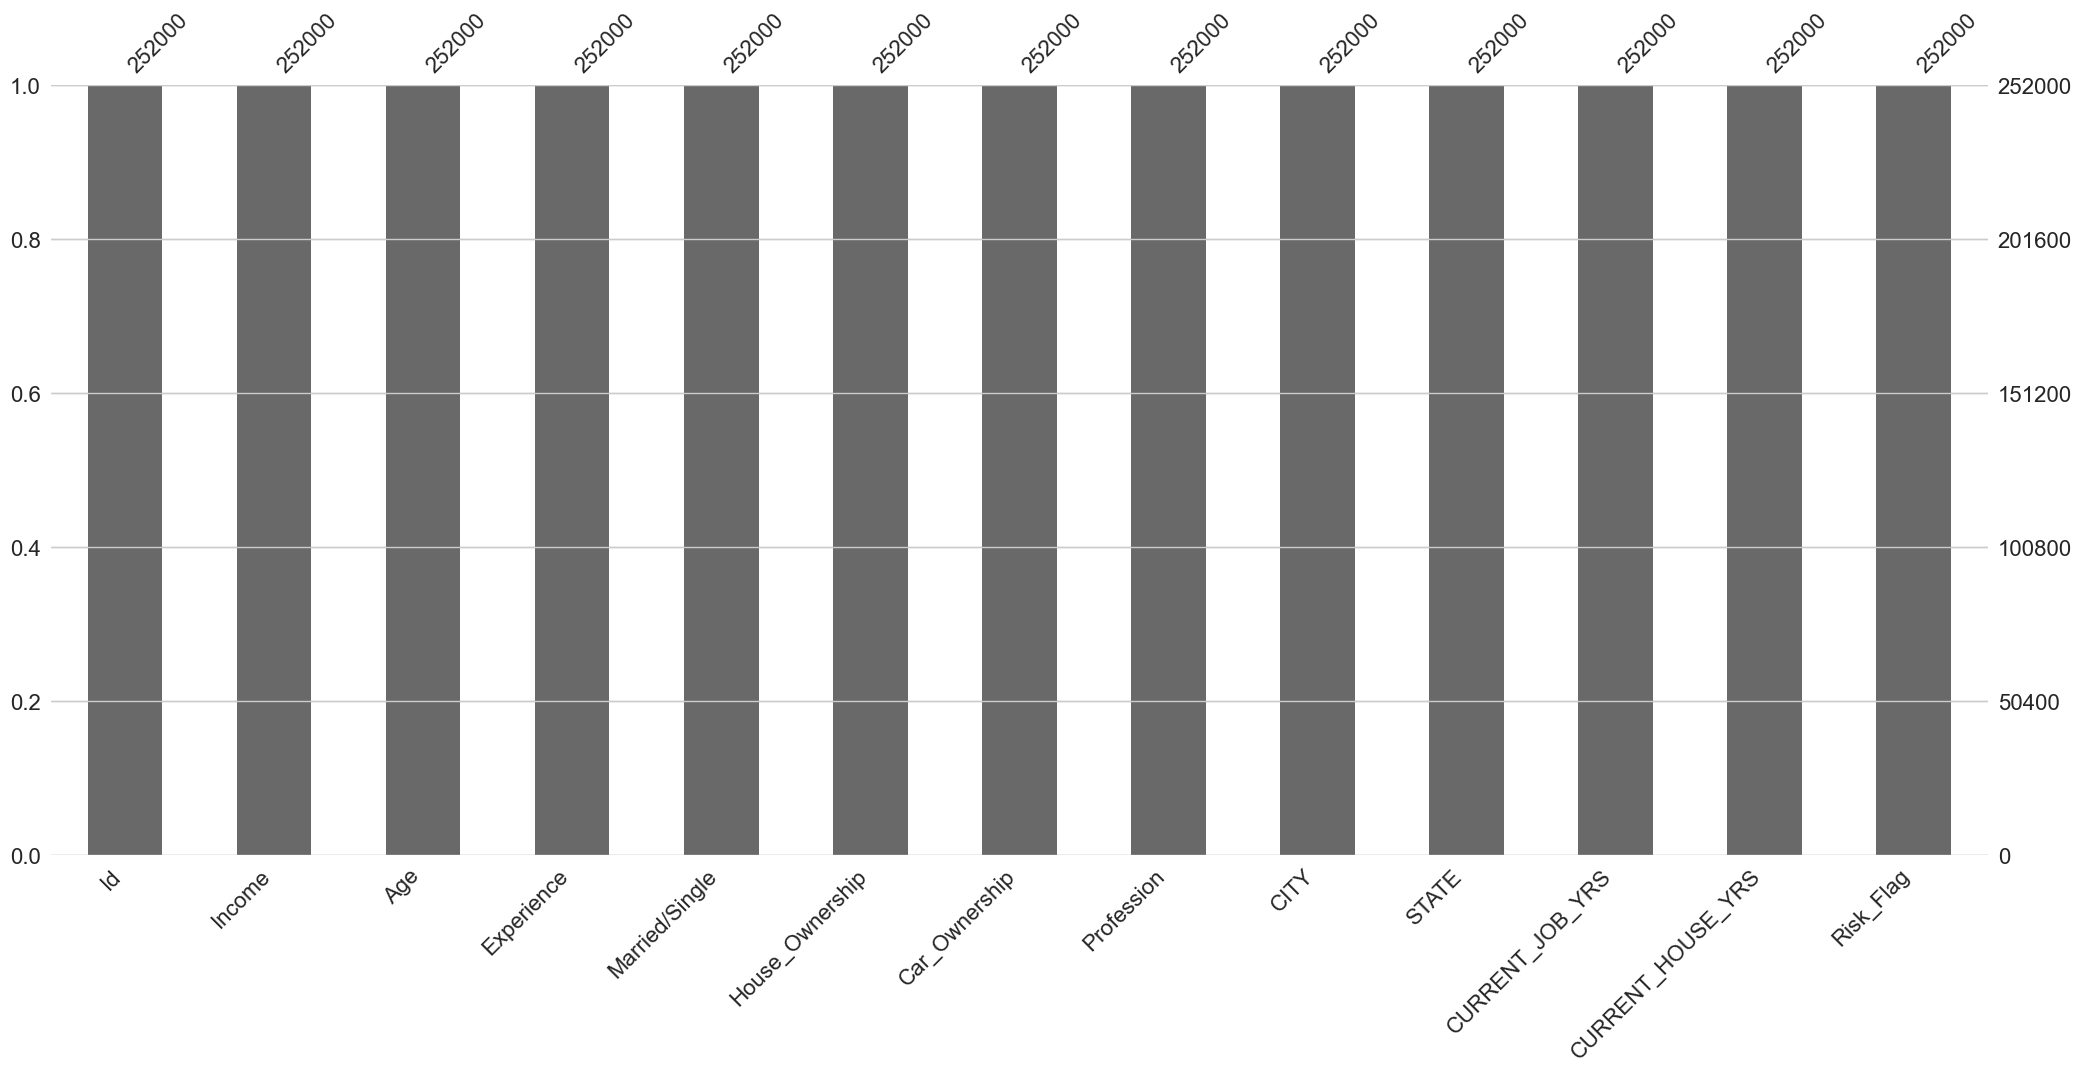

In [160]:
print('There are no missing values')
ax = msno.bar(df)

# ax = msno.bar(df.sample(500))

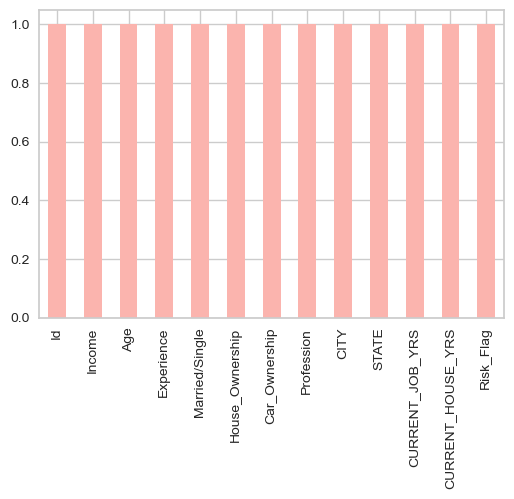

In [161]:
#https://matplotlib.org/2.0.2/examples/color/colormaps_reference.html
# colormap='Pastel1','Pastel2'
# colormap='Set1', 'Set2', 'Set3'

fig, ax = plt.subplots(figsize=(6, 4))
(1 - df.isnull().mean()).abs().plot.bar(ax=ax, colormap='Pastel1');

In [162]:
df.describe()

Id        Income            Age     Experience  \
count  252000.000000  2.520000e+05  252000.000000  252000.000000   
mean   126000.500000  4.997117e+06      49.954071      10.084437   
std     72746.278255  2.878311e+06      17.063855       6.002590   
min         1.000000  1.031000e+04      21.000000       0.000000   
25%     63000.750000  2.503015e+06      35.000000       5.000000   
50%    126000.500000  5.000694e+06      50.000000      10.000000   
75%    189000.250000  7.477502e+06      65.000000      15.000000   
max    252000.000000  9.999938e+06      79.000000      20.000000   

       CURRENT_JOB_YRS  CURRENT_HOUSE_YRS      Risk_Flag  
count    252000.000000      252000.000000  252000.000000  
mean          6.333877          11.997794       0.123000  
std           3.647053           1.399037       0.328438  
min           0.000000          10.000000       0.000000  
25%           3.000000          11.000000       0.000000  
50%           6.000000          12.000000       0.000000  
75%           9.000000          13.000000       0.000000  
max          14.000000          14.000000       1.000000

In [163]:
# Removing duplicate rows if any
df.drop_duplicates(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 252000 entries, 0 to 251999
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Id                 252000 non-null  int64 
 1   Income             252000 non-null  int64 
 2   Age                252000 non-null  int64 
 3   Experience         252000 non-null  int64 
 4   Married/Single     252000 non-null  object
 5   House_Ownership    252000 non-null  object
 6   Car_Ownership      252000 non-null  object
 7   Profession         252000 non-null  object
 8   CITY               252000 non-null  object
 9   STATE              252000 non-null  object
 10  CURRENT_JOB_YRS    252000 non-null  int64 
 11  CURRENT_HOUSE_YRS  252000 non-null  int64 
 12  Risk_Flag          252000 non-null  int64 
dtypes: int64(7), object(6)
memory usage: 26.9+ MB


In [164]:
print('Columns:\n\n',df.columns)

Columns:

 Index(['Id', 'Income', 'Age', 'Experience', 'Married/Single',
       'House_Ownership', 'Car_Ownership', 'Profession', 'CITY', 'STATE',
       'CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS', 'Risk_Flag'],
      dtype='object')


# Defining the problem statement:
An organization wants to predict who possible defaulters are for the consumer loans product.
Create a Predictive model which can tell whether a client will be risky or not based on his/her personal information.

    Target Variable: Risk_Flag
    Predictors: 'Age', 'Experience', 'Married/Single', 'House_Ownership', 'Car_Ownership', 'Profession'...etc.
    
    Non-Defaulter=0 means its not risky
    Defaulter=1 means its risky   
    
## Determining the type of Machine Learning

    Based on the problem statement you can understand that we need to create a supervised ML Classification model, as the       target variable is Continuous.

## Looking at the distribution of Target variable

    If target variable's distribution is too skewed then the predictive modeling will not be possible.
    Bell curve is desirable but slightly positive skew or negative skew is also fine
    When performing Classification, make sure the histogram looks like a bell curve or slight skewed version of it.         Otherwise it impacts the Machine Learning algorithms ability to learn all the scenarios.

<AxesSubplot:title={'center':'Non Defaulter Vs Defaulter'}, xlabel='Risk_Flag'>

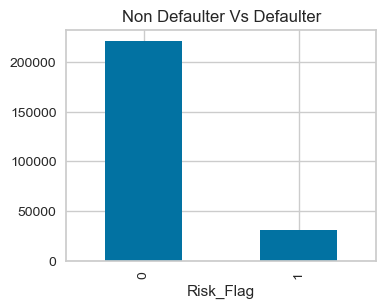

In [165]:
# Creating Bar chart as the Target variable is Categorical
GroupedData = df.groupby('Risk_Flag').size()
GroupedData.plot(kind='bar', figsize=(4,3), title='Non Defaulter Vs Defaulter')

The Target variable distribution looks imbalanced. There are no enough number of rows for Non Defaulter=0 as well Defaulter=1 for the ML algorithms to learn. We can apply SMOTE.


# Basic Data Exploration

This step is performed to guage the overall data. The volume of data, the types of columns present in the data. Initial assessment of the data should be done to identify which columns are Quantitative, Categorical or Qualitative.

This step helps to start the column rejection process. You must look at each column carefully and ask, does this column affect the values of the Target variable? For example in this case study, you will ask, does this column affect the price of the computer? If the answer is a clear "No", then remove the column immediately from the data, otherwise keep the column for further analysis.

There are four commands which are used for Basic data exploration in Python

    head() : This helps to see a few sample rows of the data
    info() : This provides the summarized information of the data
    describe() : This provides the descriptive statistical details of the data
    nunique(): This helps us to identify if a column is categorical or continuous



In [166]:
# Looking at the descriptive statistics of the data
df.describe(include='all')

Id        Income            Age     Experience  \
count   252000.000000  2.520000e+05  252000.000000  252000.000000   
unique            NaN           NaN            NaN            NaN   
top               NaN           NaN            NaN            NaN   
freq              NaN           NaN            NaN            NaN   
mean    126000.500000  4.997117e+06      49.954071      10.084437   
std      72746.278255  2.878311e+06      17.063855       6.002590   
min          1.000000  1.031000e+04      21.000000       0.000000   
25%      63000.750000  2.503015e+06      35.000000       5.000000   
50%     126000.500000  5.000694e+06      50.000000      10.000000   
75%     189000.250000  7.477502e+06      65.000000      15.000000   
max     252000.000000  9.999938e+06      79.000000      20.000000   

       Married/Single House_Ownership Car_Ownership Profession           CITY  \
count          252000          252000        252000     252000         252000   
unique              2               3             2         51            317   
top            single          rented            no  Physician  Vijayanagaram   
freq           226272          231898        176000       5957           1259   
mean              NaN             NaN           NaN        NaN            NaN   
std               NaN             NaN           NaN        NaN            NaN   
min               NaN             NaN           NaN        NaN            NaN   
25%               NaN             NaN           NaN        NaN            NaN   
50%               NaN             NaN           NaN        NaN            NaN   
75%               NaN             NaN           NaN        NaN            NaN   
max               NaN             NaN           NaN        NaN            NaN   

                STATE  CURRENT_JOB_YRS  CURRENT_HOUSE_YRS      Risk_Flag  
count          252000    252000.000000      252000.000000  252000.000000  
unique             29              NaN                NaN            NaN  
top     Uttar_Pradesh              NaN                NaN            NaN  
freq            28400              NaN                NaN            NaN  
mean              NaN         6.333877          11.997794       0.123000  
std               NaN         3.647053           1.399037       0.328438  
min               NaN         0.000000          10.000000       0.000000  
25%               NaN         3.000000          11.000000       0.000000  
50%               NaN         6.000000          12.000000       0.000000  
75%               NaN         9.000000          13.000000       0.000000  
max               NaN        14.000000          14.000000       1.000000

In [167]:
# Finging unique values for each column
# TO understand which column is categorical and which one is Continuous
# Typically if the numer of unique values are < 20 then the variable is 
# likely to be a category otherwise continuous
df.nunique()

Id                   252000
Income                41920
Age                      59
Experience               21
Married/Single            2
House_Ownership           3
Car_Ownership             2
Profession               51
CITY                    317
STATE                    29
CURRENT_JOB_YRS          15
CURRENT_HOUSE_YRS         5
Risk_Flag                 2
dtype: int64

## Basic Data Exploration Results

Based on the basic exploration above, you can now create a simple report of the data, nothing down your observations regaring each column. Hence, creating a initial roadmap for further analysis.

The selected columns in this step are not final, further study will be done and then a final list will be created.

    'Id': Qualitative. Rejected. This column does not affect the Risk Flag
    'Income': Continuous. Selected.
    'Age': Continuous. Selected.
    'Experience': Continuous. Selected.
    'Married/Single': Categorical. Selected.
    'House_Ownership': Categorical. Selected.
    'Car_Ownership': Categorical. Selected.
    'Profession': Categorical. Selected.
    'CITY': Qualitative. Rejected. This column does not affect the Risk Flag
    'STATE': Qualitative. Rejected. This column does not affect the Risk Flag
    'CURRENT_JOB_YRS': Continuous. Selected
    'CURRENT_HOUSE_YRS': Continuous. Selected
    'Risk_Flag': Continuous. Selected.

## Removing useless columns from the data

In [3]:
# Deleting those columns which are not useful in predictive analysis 
# because these variables are qualitative
UselessColumns = ['Id','CITY','STATE']

df = df.drop(UselessColumns,axis=1)
df.head()

Income  Age  Experience Married/Single House_Ownership Car_Ownership  \
0  1303834   23           3         single          rented            no   
1  7574516   40          10         single          rented            no   
2  3991815   66           4        married          rented            no   
3  6256451   41           2         single          rented           yes   
4  5768871   47          11         single          rented            no   

            Profession  CURRENT_JOB_YRS  CURRENT_HOUSE_YRS  Risk_Flag  
0  Mechanical_engineer                3                 13          0  
1   Software_Developer                9                 13          0  
2     Technical_writer                4                 10          0  
3   Software_Developer                2                 12          1  
4        Civil_servant                3                 14          1

## Visual Exploratory Data Analysis

    Categorical variables: Bar plot
    Continuous variables: Histogram

Visualize distribution of all the Categorical Predictor variables in the data using bar plots

We can spot a categorical variable in the data by looking at the unique values in them. Typically a categorical variable contains less than 20 Unique values AND there is repetition of values, which means the data can be grouped by those unique values.

Based on the Basic Data Exploration above, we have spotted six categorical predictors in the data

Categorical Predictors: 'Married/Single','House_Ownership','Car_Ownership','Profession'

We use bar charts to see how the data is distributed for these categorical columns.

In [169]:
# Plotting multiple bar charts at once for categorical variables
# Since there is no default function which can plot bar charts for multiple columns at once
# we are defining our own function for the same

def PlotBarCharts(inpData, colsToPlot):
    # Generating multiple subplots
    fig, subPlot=plt.subplots(nrows=1, ncols=len(colsToPlot), figsize=(20,5))
    fig.suptitle('Bar Charts of:'+ str(colsToPlot))
    
    for colName, plotNumber in zip(colsToPlot, range(len(colsToPlot))):
        inpData.groupby(colName).size().plot(kind='bar',ax=subPlot[plotNumber])    

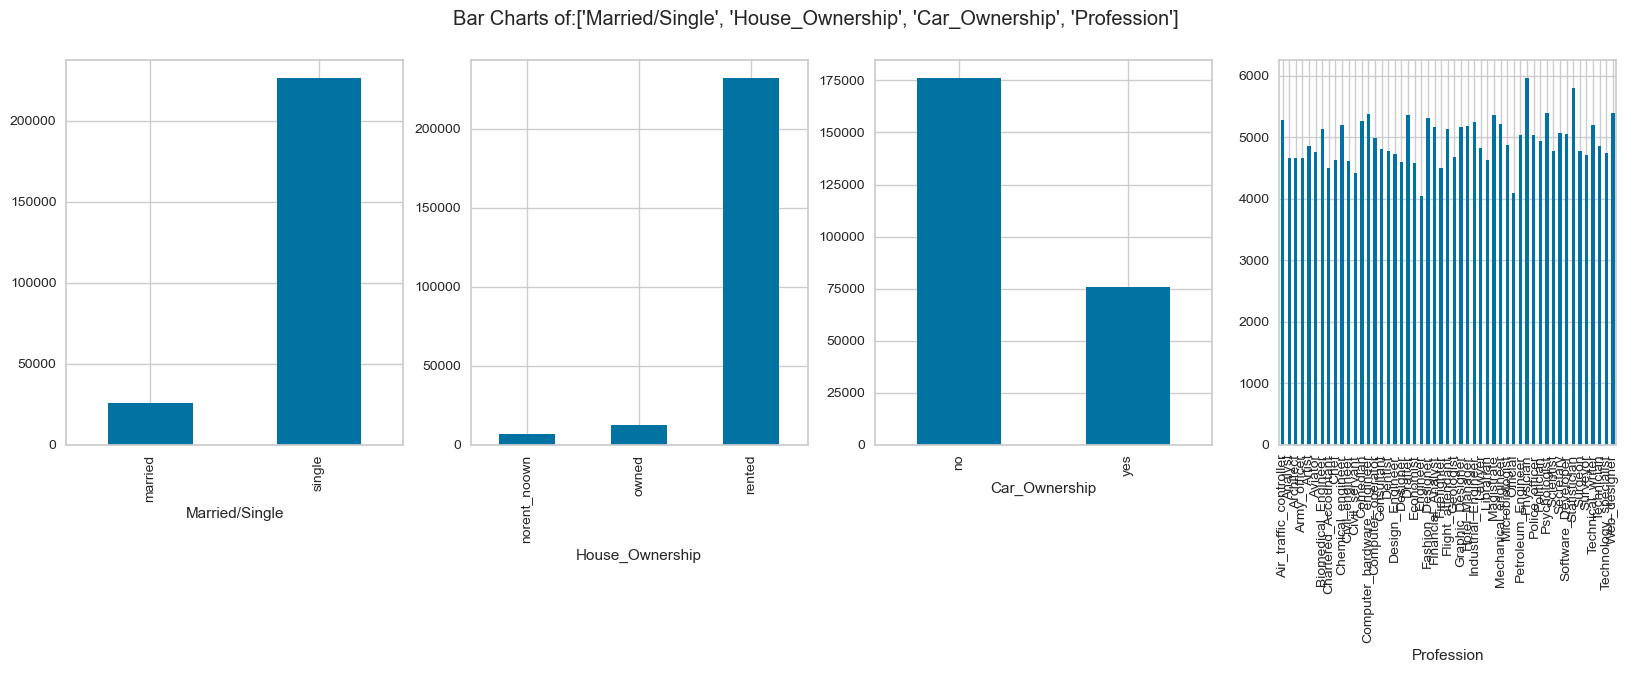

In [170]:
# Calling the function
PlotBarCharts(inpData=df, colsToPlot=['Married/Single','House_Ownership','Car_Ownership','Profession']);

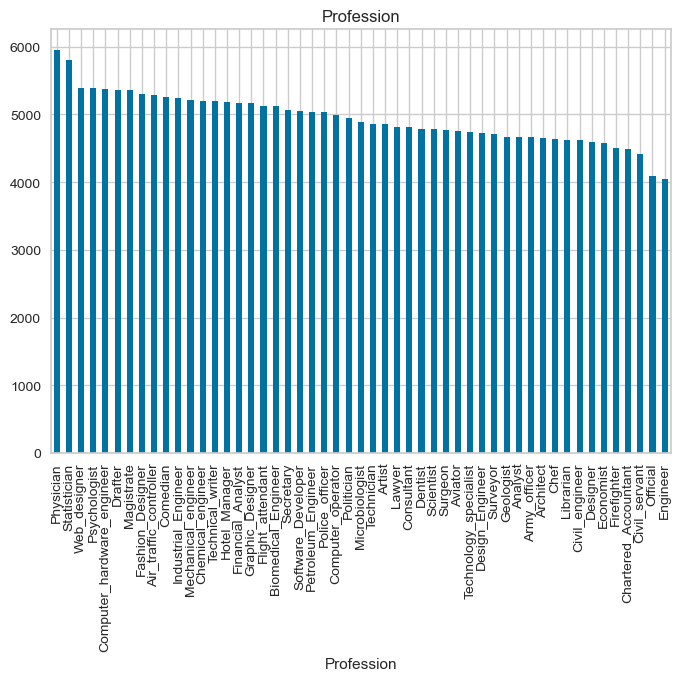

In [171]:
df['Profession'].value_counts().plot(kind='bar')
plt.xlabel('Profession')
plt.title('Profession')
plt.show()

## Bar Charts Interpretation

These bar charts represent the frequencies of each category in the Y-axis and the category names in the X-axis.

In the ideal bar chart each category has comparable frequency. Hence, there are enough rows for each category in the data for the ML algorithm to learn.

If there is a column which shows too skewed distribution where there is only one dominant bar and the other categories are present in very low numbers. These kind of columns may not be very helpful in machine learning. We confirm this in the correlation analysis section and take a final call to select or reject the column.

In this data, all the categorical columns have satisfactory distribution to be considered for machine learning.

Selected Categorical Variables: All the categorical variables are selected for further analysis.

'Married/Single','House_Ownership','Car_Ownership','Profession'


## Visualize distribution of all the Continuous Predictor variables in the data using histograms

Based on the Basic Data Exploration, there five continuous predictor variables 'Income','Age','Experience', 'CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS'

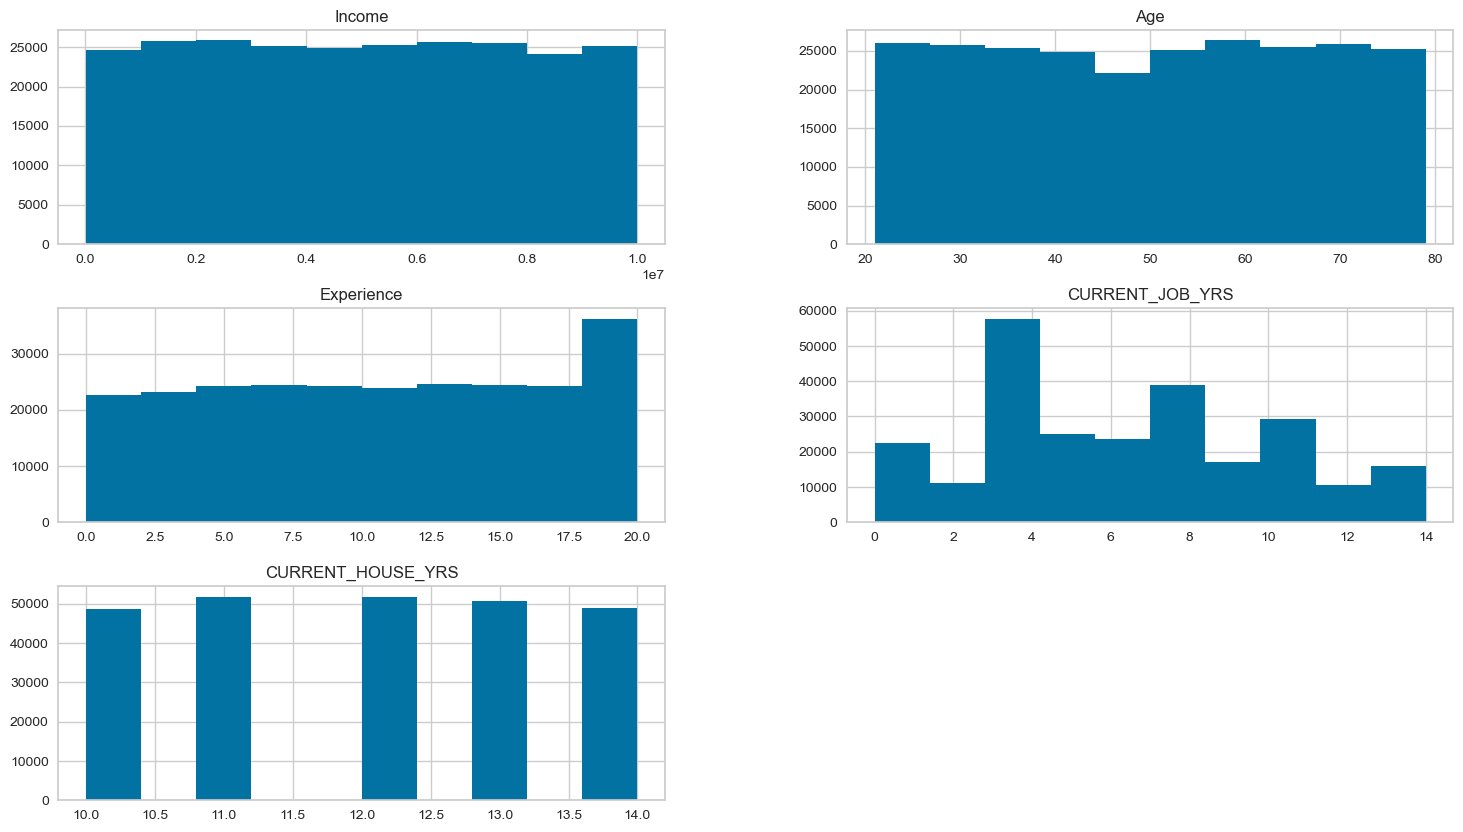

In [172]:
# Plotting histograms of multiple columns together
df.hist(['Income','Age','Experience', 'CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS'], figsize=(18,10));

## Histogram Interpretation

Histograms shows us the data distribution for a single continuous variable.

The ideal outcome for histogram is a bell curve or slightly skewed bell curve. If there is too much skewness, then outlier treatment should be done and the column should be re-examined, if that also does not solve the problem then only reject the column.

Selected Continuous Variables:

    Income : Selected.
    Experience: Selected.
    CURRENT_JOB_YRS: Selected. Slightly negative skewed distribution, acceptable.
    CURRENT_HOUSE_YRS: Selected.


## Outlier treatment

Outliers are extreme values in the data which are far away from most of the values. You can see them as the tails in the histogram.

Outlier must be treated one column at a time. As the treatment will be slightly different for each column.

Why I should treat the outliers?

Outliers bias the training of machine learning models. As the algorithm tries to fit the extreme value, it goes away from majority of the data.

There are below two options to treat outliers in the data.

    Option-1: Delete the outlier Records. Only if there are just few rows lost.
    Option-2: Impute the outlier values with a logical business value

In this data no prominent outliers are present, hence, not treating outlier in this section


# Missing values treatment

Missing values are treated for each column separately.

If a column has more than 30% data missing, then missing value treatment cannot be done. That column must be rejected because too much information is missing.

There are below options for treating missing values in data.

    Delete the missing value rows if there are only few records
    Impute the missing values with MEDIAN value for continuous variables
    Impute the missing values with MODE value for categorical variables
    Interpolate the values based on nearby values
    Interpolate the values based on business logic

In [173]:
# Finding how many missing values are there for each column
df.isnull().sum()

Income               0
Age                  0
Experience           0
Married/Single       0
House_Ownership      0
Car_Ownership        0
Profession           0
CURRENT_JOB_YRS      0
CURRENT_HOUSE_YRS    0
Risk_Flag            0
dtype: int64

# Feature Selection

Now its time to finally choose the best columns(Features) which are correlated to the Target variable. This can be done directly by measuring the correlation values or ANOVA/Chi-Square tests. However, it is always helpful to visualize the relation between the Target variable and each of the predictors to get a better sense of data.

I have listed below the techniques used for visualizing relationship between two variables as well as measuring the strength statistically.

## Visual exploration of relationship between variables

    Continuous Vs Continuous ---- Scatter Plot
    Categorical Vs Continuous---- Box Plot
    Categorical Vs Categorical---- Grouped Bar Plots

## Statistical measurement of relationship strength between variables

    Continuous Vs Continuous ---- Correlation matrix
    Categorical Vs Continuous---- ANOVA test
    Categorical Vs Categorical--- Chi-Square test

In this case study the Target variable is Continuous, hence below two scenarios will be present

    Continuous Target Variable Vs Continuous Predictor
    Continuous Target Variable Vs Categorical Predictor

## Relationship exploration: Continuous Vs Continuous -- Box Plots

When the target variable is Categorical and the predictor variable is Continuous we analyze the relation using bar plots/Boxplots and measure the strength of relation using Anova test

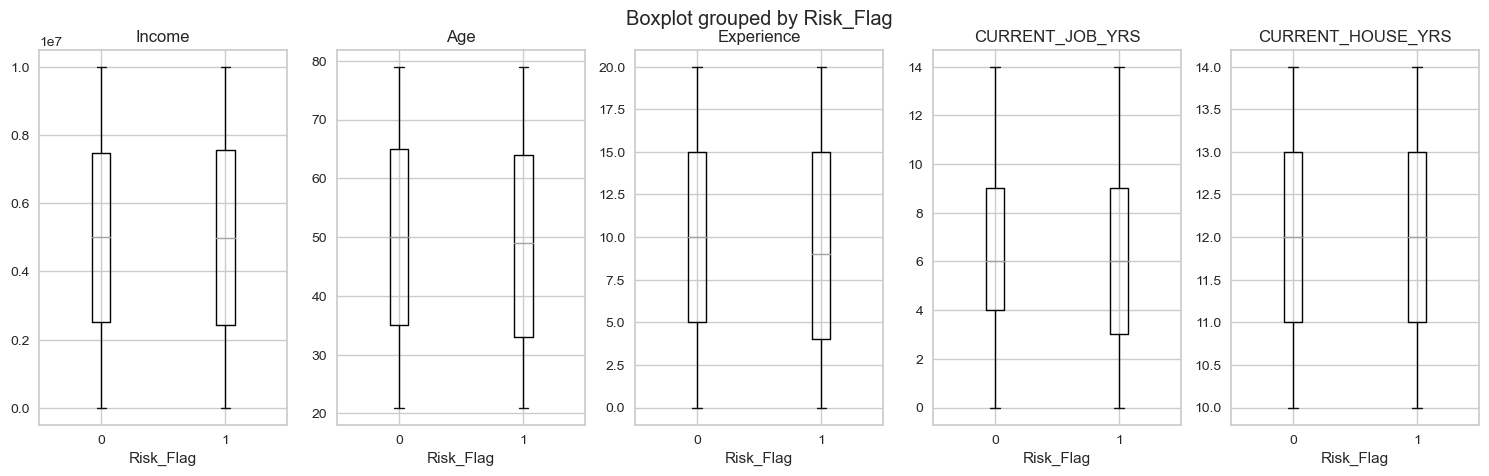

In [174]:
# Box plots for Categorical Target Variable 'Risk_Flag' and continuous predictors
ContinuousColsList = ['Income','Age','Experience', 'CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS']

fig, PlotCanvas=plt.subplots(nrows=1, ncols=len(ContinuousColsList), figsize=(18,5))

# Creating box plots for each continuous predictor against the Target Variable 'Risk_Flag'
for PredictorCol, i in zip(ContinuousColsList, range(len(ContinuousColsList))):
    df.boxplot(column=PredictorCol, by='Risk_Flag', figsize=(5,5), vert=True, ax=PlotCanvas[i])

## Box-Plots interpretation

What should you look for in these box plots?

These plots gives an idea about the data distribution of continuous predictor in the Y-axis for each of the category in the X-Axis.

If the distribution looks similar for each category(Boxes are in the same line), that means the the continuous variable has NO effect on the target variable. Hence, the variables are not correlated to each other.

We confirm this by looking at the results of ANOVA test below

## Statistical Feature Selection (Categorical Vs Continuous) using ANOVA test

Analysis of variance(ANOVA) is performed to check if there is any relationship between the given continuous and categorical variable

    Assumption(H0): There is NO relation between the given variables (i.e. The average(mean) values of the numeric Target variable is same for all the groups in the categorical Predictor variable)
    ANOVA Test result: Probability of H0 being true

In [175]:
# Defining a function to find the statistical relationship with all the categorical variables
def FunctionAnova(inpData, TargetVariable, ContinuousPredictorList):
    # Creating an empty list of final selected predictors
    SelectedPredictors=[]
    
    print('##### ANOVA Results ##### \n')
    for predictor in ContinuousPredictorList:
        CategoryGroupLists=inpData.groupby(TargetVariable)[predictor].apply(list)
        AnovaResults = f_oneway(*CategoryGroupLists)
        
        # If the ANOVA P-Value is <0.05, that means we reject H0
        if (AnovaResults[1] < 0.05):
            print(predictor, 'is correlated with', TargetVariable, '| P-Value:', AnovaResults[1])
            SelectedPredictors.append(predictor)
        else:
            print(predictor, 'is NOT correlated with', TargetVariable, '| P-Value:', AnovaResults[1])
    return(SelectedPredictors)

In [176]:
# Calling the function to check which categorical variables are correlated with target
ContinuousVariables=['Income','Age','Experience', 'CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS']
FunctionAnova(inpData=df, TargetVariable='Risk_Flag', ContinuousPredictorList=ContinuousVariables)

##### ANOVA Results ##### 

Income is NOT correlated with Risk_Flag | P-Value: 0.1207220319583281
Age is correlated with Risk_Flag | P-Value: 6.687623647499306e-28
Experience is correlated with Risk_Flag | P-Value: 2.5475634865752383e-67
CURRENT_JOB_YRS is correlated with Risk_Flag | P-Value: 1.813221223267855e-17
CURRENT_HOUSE_YRS is correlated with Risk_Flag | P-Value: 0.028069472774381213


['Age', 'Experience', 'CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS']

The results of ANOVA confirm our visual analysis using box plots above.

Four columns are correlated with 'Risk_Flag' (Target Variable) except Income


## Relationship exploration: Categorical Vs Categorical -- Grouped Bar Charts

When the target variable is Categorical and the predictor is also Categorical then we explore the correlation between them visually using barplots and statistically using Chi-square test

In [177]:
# Cross tablulation between two categorical variables
CrossTabResult = pd.crosstab(df['House_Ownership'], df['Risk_Flag'])
CrossTabResult

Risk_Flag             0      1
House_Ownership               
norent_noown       6469    715
owned             11758   1160
rented           202777  29121

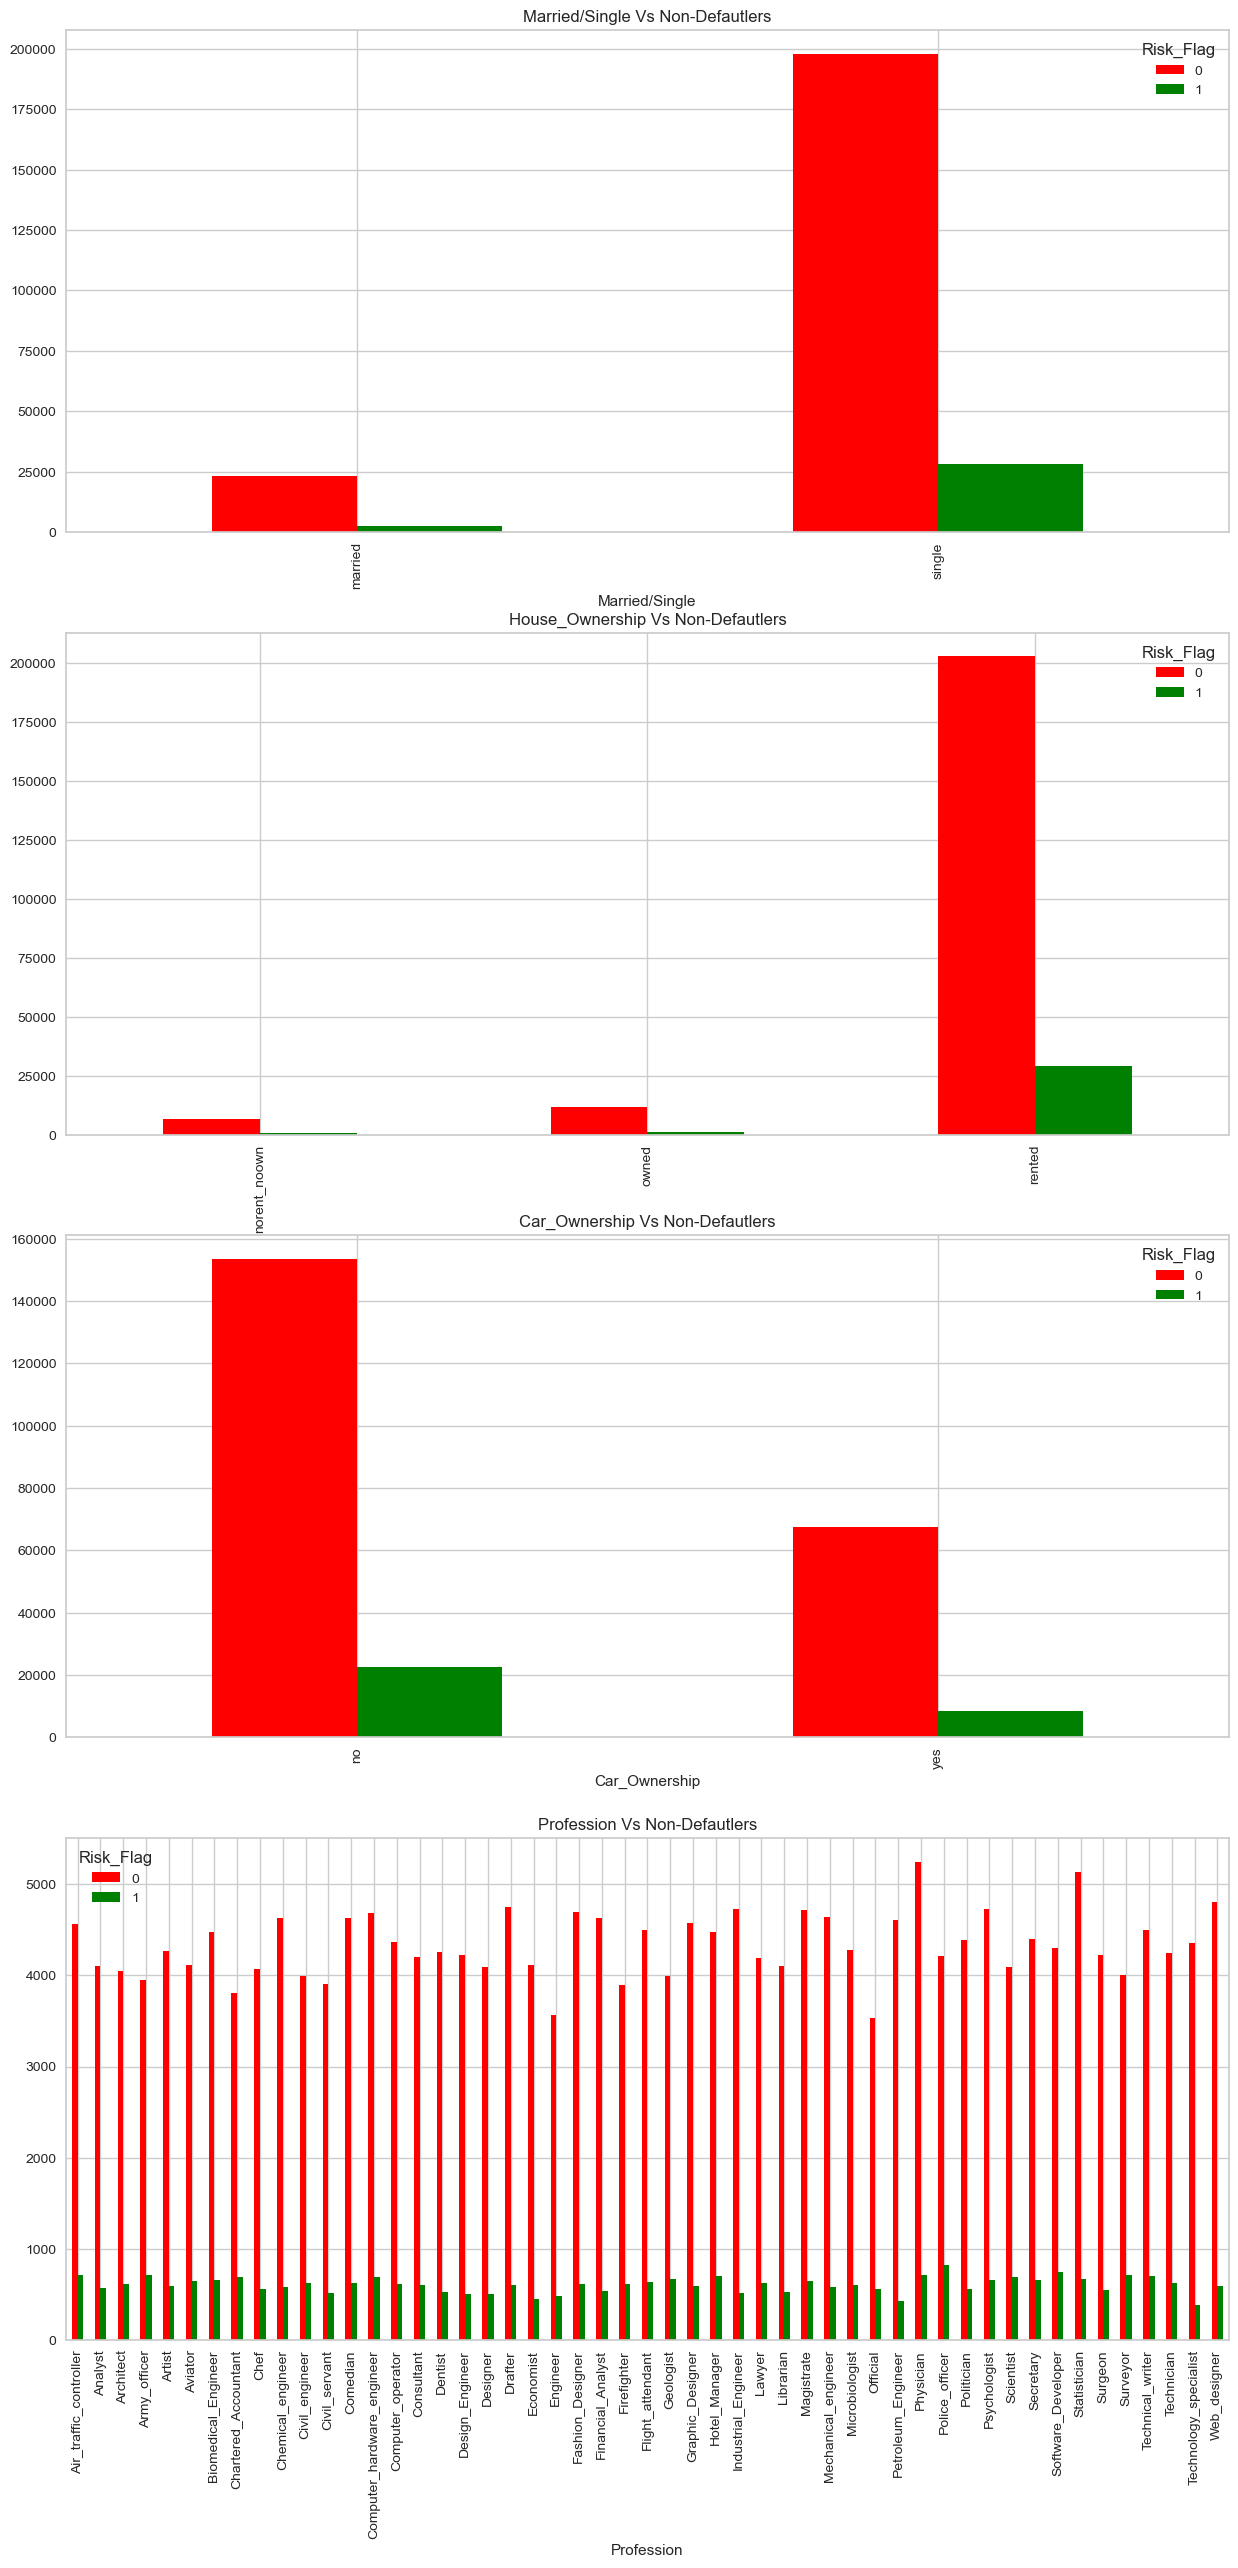

In [178]:
# Visual Inference using Grouped Bar charts
CategoricalColsList=['Married/Single','House_Ownership','Car_Ownership','Profession']

fig, PlotCanvas=plt.subplots(nrows=len(CategoricalColsList), ncols=1, figsize=(15,30))

# Creating Grouped bar plots for each categorical predictor against the Target Variable "Survived"
for CategoricalCol , i in zip(CategoricalColsList, range(len(CategoricalColsList))):
    CrossTabResult=pd.crosstab(index=df[CategoricalCol], columns=df['Risk_Flag'])
    CrossTabResult.plot.bar(color=['red','green'], ax=PlotCanvas[i], title=CategoricalCol+' Vs Non-Defautlers')

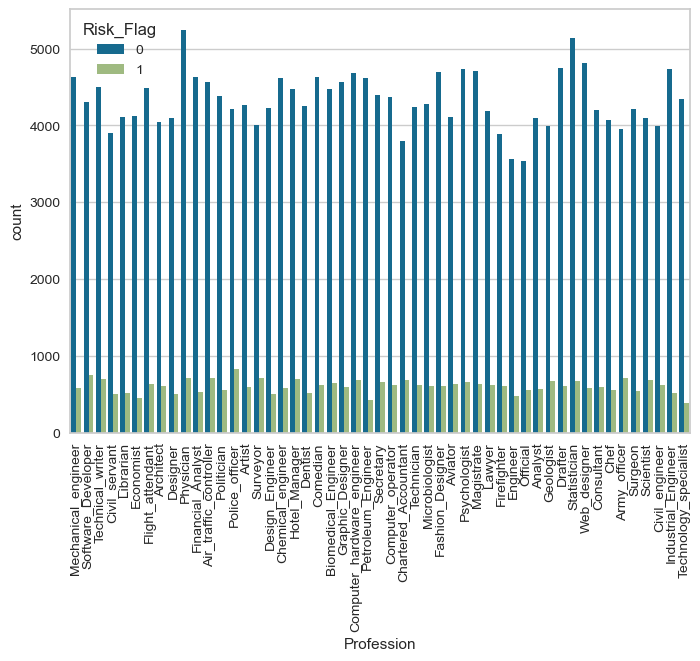

In [179]:
sns.countplot(x='Profession', hue='Risk_Flag', data=df)
plt.xticks(rotation=90)
plt.show();

## Grouped Bar charts Interpretation

What to look for in these grouped bar charts?

These grouped bar charts show the frequency in the Y-Axis and the category in the X-Axis. If the ratio of bars is similar across all categories, then the two columns are not correlated.

We confirm this analysis in below section by using Chi-Square Tests.

### Statistical Feature Selection (Categorical Vs Categorical) using Chi-Square Test

Chi-Square test is conducted to check the correlation between two categorical variables

    Assumption(H0): The two columns are NOT related to each other
    Result of Chi-Sq Test: The Probability of H0 being True
    More information on ChiSq: https://www.mathsisfun.com/data/chi-square-test.html

In [180]:
# Writing a function to find the correlation of all categorical variables with the Target variable
def FunctionChisq(inpData, TargetVariable, CategoricalVariablesList):
    from scipy.stats import chi2_contingency
    
    # Creating an empty list of final selected predictors
    SelectedPredictors=[]

    for predictor in CategoricalVariablesList:
        CrossTabResult=pd.crosstab(index=inpData[TargetVariable], columns=inpData[predictor])
        ChiSqResult = chi2_contingency(CrossTabResult)
        
        # If the ChiSq P-Value is <0.05, that means we reject H0
        if (ChiSqResult[1] < 0.05):
            print(predictor, 'is correlated with', TargetVariable, '| P-Value:', ChiSqResult[1])
            SelectedPredictors.append(predictor)
        else:
            print(predictor, 'is NOT correlated with', TargetVariable, '| P-Value:', ChiSqResult[1])        
            
    return(SelectedPredictors)

In [181]:
CategoricalVariables=['Married/Single','House_Ownership','Car_Ownership','Profession']

# Calling the function
FunctionChisq(inpData=df, 
              TargetVariable='Risk_Flag',
              CategoricalVariablesList= CategoricalVariables)

Married/Single is correlated with Risk_Flag | P-Value: 3.7730537057152214e-26
House_Ownership is correlated with Risk_Flag | P-Value: 1.8381930028370595e-40
Car_Ownership is correlated with Risk_Flag | P-Value: 1.7350853850183746e-33
Profession is correlated with Risk_Flag | P-Value: 5.108641602000937e-98


['Married/Single', 'House_Ownership', 'Car_Ownership', 'Profession']

# Selecting final predictors for Machine Learning

Based on the above tests, selecting the final columns for machine learning

In [4]:
SelectedColumns=['Income','Age', 'Experience', 'CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS',
                'Married/Single', 'House_Ownership', 'Car_Ownership', 'Profession']
DataForML=df[SelectedColumns]
DataForML.head()

Income  Age  Experience  CURRENT_JOB_YRS  CURRENT_HOUSE_YRS  \
0  1303834   23           3                3                 13   
1  7574516   40          10                9                 13   
2  3991815   66           4                4                 10   
3  6256451   41           2                2                 12   
4  5768871   47          11                3                 14   

  Married/Single House_Ownership Car_Ownership           Profession  
0         single          rented            no  Mechanical_engineer  
1         single          rented            no   Software_Developer  
2        married          rented            no     Technical_writer  
3         single          rented           yes   Software_Developer  
4         single          rented            no        Civil_servant

In [5]:
# Encoding Categorical variables into numerical variables

# Select the categorical columns
cat_data = ['Married/Single', 'House_Ownership', 'Car_Ownership', 'Profession']

# Define the encoder
encoder = ce.OrdinalEncoder(cols=cat_data, return_df=True)

# Fit and transform the encoder on the entire dataset
encoded_cat_data = encoder.fit_transform(df)

In [6]:
# Making these changes permanent
df[cat_data] = encoded_cat_data[cat_data]

In [7]:
df.head()

Income  Age  Experience  Married/Single  House_Ownership  Car_Ownership  \
0  1303834   23           3               1                1              1   
1  7574516   40          10               1                1              1   
2  3991815   66           4               2                1              1   
3  6256451   41           2               1                1              2   
4  5768871   47          11               1                1              1   

   Profession  CURRENT_JOB_YRS  CURRENT_HOUSE_YRS  Risk_Flag  
0           1                3                 13          0  
1           2                9                 13          0  
2           3                4                 10          0  
3           2                2                 12          1  
4           4                3                 14          1

## Data Pre-processing for Machine Learning

List of steps performed on predictor variables before data can be used for machine learning

    Converting each Ordinal Categorical columns to numeric
    Converting Binary nominal Categorical columns to numeric using 1/0 mapping
    Converting all other nominal categorical columns to numeric using pd.get_dummies()
    Data Transformation (Optional): Standardization/Normalization/log/sqrt. Important if you are using distance based algorithms like KNN, or Neural Networks

In [8]:
# Separate Target Variable and Predictor Variables
TargetVariable = 'Risk_Flag'
Predictors = ['Income','Age', 'Experience', 'CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS',
                'Married/Single', 'House_Ownership', 'Car_Ownership', 'Profession']
print(TargetVariable, Predictors)

Risk_Flag ['Income', 'Age', 'Experience', 'CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS', 'Married/Single', 'House_Ownership', 'Car_Ownership', 'Profession']


In [9]:
X = df.drop(['Risk_Flag'], axis=1)
y = df['Risk_Flag']

print(X,y)

         Income  Age  Experience  Married/Single  House_Ownership  \
0       1303834   23           3               1                1   
1       7574516   40          10               1                1   
2       3991815   66           4               2                1   
3       6256451   41           2               1                1   
4       5768871   47          11               1                1   
...         ...  ...         ...             ...              ...   
251995  8154883   43          13               1                1   
251996  2843572   26          10               1                1   
251997  4522448   46           7               1                1   
251998  6507128   45           0               1                1   
251999  9070230   70          17               1                1   

        Car_Ownership  Profession  CURRENT_JOB_YRS  CURRENT_HOUSE_YRS  
0                   1           1                3                 13  
1                   1      

In [10]:
X.shape, y.shape

((252000, 9), (252000,))

In [11]:
# Split the data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [12]:
# Display the rows and columns (dimensions) of an unsplitted dataset
print('Total number of rows and columns for the complete dataset: ', X.shape, y.shape)

# Display the rows and columns (dimensions) of the splitted dataset
print('Number of rows and columns after splitting dataset: ', X_train.shape, X_test.shape, y_train.shape, y_test.shape)

Total number of rows and columns for the complete dataset:  (252000, 9) (252000,)
Number of rows and columns after splitting dataset:  (176400, 9) (75600, 9) (176400,) (75600,)


## SMOTE

In [13]:
smt = SMOTE(random_state = 42)
X_train_res, y_train_res = smt.fit_resample(X_train, y_train)

In [14]:
print('\nClass distribution before SMOTE: \n', pd.Series(y_train).value_counts())
print('\nClass distribution after SMOTE: \n', pd.Series(y_train_res).value_counts())


Class distribution before SMOTE: 
 0    154675
1     21725
Name: Risk_Flag, dtype: int64

Class distribution after SMOTE: 
 0    154675
1    154675
Name: Risk_Flag, dtype: int64


## Standardization/Normalization of data

You can choose not to run this step if you want to compare the resultant accuracy of this transformation with the accuracy of raw data.

However, if you are using KNN or Neural Networks, then this step becomes necessary.

In [15]:
# select the continuous numerical variables
cont_num_var = ['Income','Age','Experience', 'CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS']

# Instantiate the MinMaxScaler 
scaler = MinMaxScaler()

# Normalize the continuous numerical variables
X_train[cont_num_var] = scaler.fit_transform(X_train[cont_num_var])

X_test[cont_num_var] = scaler.transform(X_test[cont_num_var])

In [16]:
print(X_train.head())
print(X_train.describe())

          Income       Age  Experience  Married/Single  House_Ownership  \
8166    0.414547  0.327586        0.60               1                1   
84279   0.349167  0.879310        0.05               1                1   
37928   0.389621  0.086207        0.25               1                1   
153707  0.688313  1.000000        0.75               2                1   
63484   0.559614  0.172414        1.00               1                1   

        Car_Ownership  Profession  CURRENT_JOB_YRS  CURRENT_HOUSE_YRS  
8166                2          46         0.785714               0.25  
84279               1          32         0.071429               0.25  
37928               1          24         0.214286               1.00  
153707              1          12         0.928571               0.75  
63484               2          38         0.500000               0.50  
              Income            Age     Experience  Married/Single  \
count  176400.000000  176400.000000  176400.000

In [17]:
print(X_test.head())
print(X_test.describe())

          Income       Age  Experience  Married/Single  House_Ownership  \
75255   0.425531  0.448276        0.90               1                1   
192435  0.852834  0.396552        0.10               1                1   
154839  0.784690  0.586207        0.45               1                1   
59774   0.849044  0.689655        1.00               1                1   
63788   0.152862  0.982759        0.65               1                1   

        Car_Ownership  Profession  CURRENT_JOB_YRS  CURRENT_HOUSE_YRS  
75255               1          13         0.500000               0.75  
192435              1          24         0.142857               0.00  
154839              1           2         0.642857               0.75  
59774               1          21         0.571429               0.25  
63788               1          43         0.642857               0.50  
             Income           Age    Experience  Married/Single  \
count  75600.000000  75600.000000  75600.000000   

# Logistic Regression

In [18]:
# Logistic Regression
# choose parameter Penalty='l1' or C=1
# choose different values for solver 'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'
clf = LogisticRegression(C=1,penalty='l2', solver='newton-cg')

# Printing all the parameters of logistic regression
print(clf)

LogisticRegression(C=1, solver='newton-cg')


In [19]:
# Creating the model on resampled Training Data
LOG=clf.fit(X_train_res, y_train_res)
y_pred = LOG.predict(X_test)

In [20]:
# Measuring accuracy on Testing Data
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.91      0.00      0.01     66329
           1       0.12      1.00      0.22      9271

    accuracy                           0.13     75600
   macro avg       0.51      0.50      0.11     75600
weighted avg       0.81      0.13      0.03     75600



In [85]:
print('LOG Test Score:',LOG.score(X_test,y_test))

LOG Test Score: 0.505462962962963


## Confusion Matrix

In [87]:
LOG.classes_

array([0, 1], dtype=int64)

In [88]:
mapping = {0:'No Risk', 1:'Risk'}
classesMapped = [mapping.get(value, value) for value in LOG.classes_]
classesMapped

['No Risk', 'Risk']

In [88]:
cm = metrics.confusion_matrix(y_test, y_pred)
print(cm)

[[32856 33473]
 [ 3914  5357]]


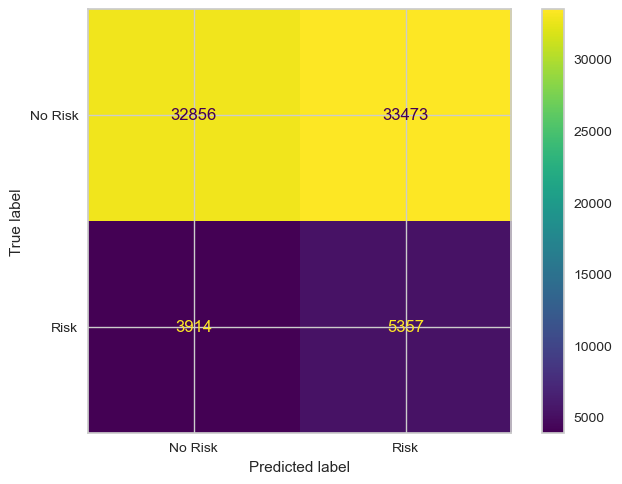

In [89]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classesMapped)

disp.plot()
plt.show()

In [201]:
# Running 10-Fold Cross validation on a given algorithm
# Passing full data X and y because the K-fold will split the data and automatically choose train/test
Accuracy_Values=cross_val_score(LOG, X , y, cv=5, scoring='f1_weighted')
print('\nAccuracy values for 10-fold Cross Validation:\n',Accuracy_Values)
print('\nFinal Average Accuracy of the model:', round(Accuracy_Values.mean(),2))


Accuracy values for 10-fold Cross Validation:
 [0.81953579 0.81953579 0.81953579 0.81953579 0.81950737]

Final Average Accuracy of the model: 0.82


# Decision Tree

In [91]:
#Decision Trees
#choose from different tunable hyper parameters
clf = DecisionTreeClassifier(criterion="entropy",random_state=42)

# Printing all the parameters of Decision Tree
print(clf)

DecisionTreeClassifier(criterion='entropy', random_state=42)


In [92]:
# Creating the model on resampled Training Data
DTree=clf.fit(X_train_res, y_train_res)
y_pred = DTree.predict(X_test)

In [94]:
# Measuring accuracy on Testing Data
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.97      0.88      0.92     66329
           1       0.48      0.83      0.61      9271

    accuracy                           0.87     75600
   macro avg       0.73      0.85      0.77     75600
weighted avg       0.91      0.87      0.88     75600



In [95]:
print('DTree Test Score:',DTree.score(X_test,y_test))

DTree Test Score: 0.870568783068783


## Confusion Matrix

In [96]:
cm = metrics.confusion_matrix(y_test, y_pred)
print(cm)

[[58108  8221]
 [ 1564  7707]]


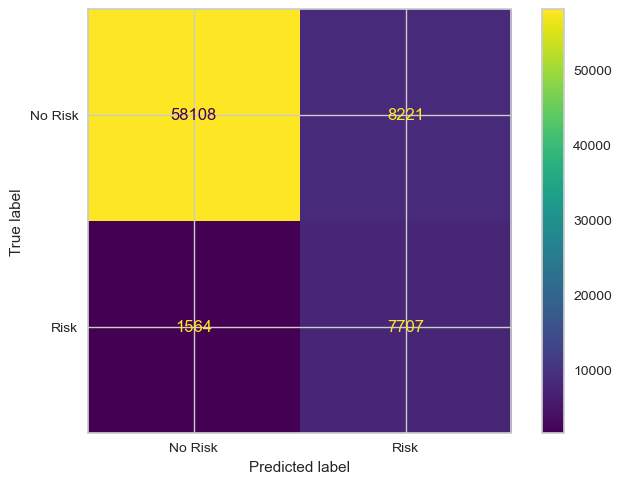

In [97]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classesMapped)

disp.plot()
plt.show()

In [212]:
# Running 10-Fold Cross validation on a given algorithm
# Passing full data X and y because the K-fold will split the data and automatically choose train/test
Accuracy_Values=cross_val_score(DTree, X , y, cv=10, scoring='f1_weighted')
print('\nAccuracy values for 10-fold Cross Validation:\n',Accuracy_Values)
print('\nFinal Average Accuracy of the model:', round(Accuracy_Values.mean(),2))


Accuracy values for 10-fold Cross Validation:
 [0.93762193 0.92332002 0.92515409 0.91331227 0.90629169 0.92028113
 0.88901964 0.88856201 0.81320715 0.70393371]

Final Average Accuracy of the model: 0.88


## Plot Feature Importances

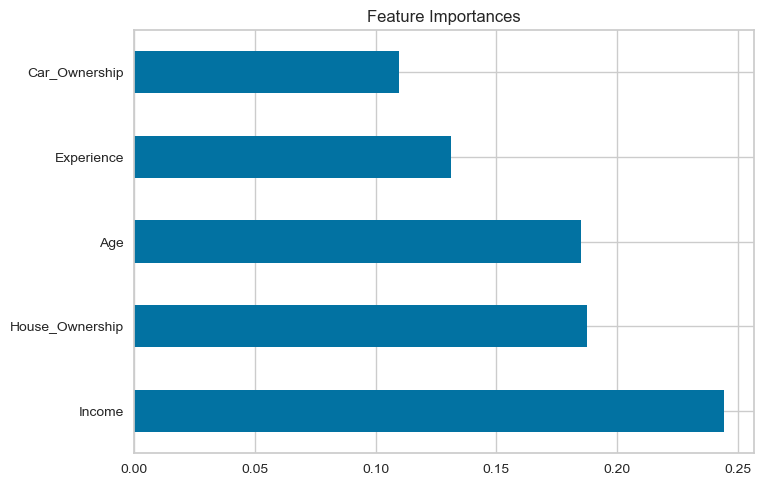

In [98]:
# Plotting the feature importance for Top 5 most important columns
feature_importances = pd.Series(DTree.feature_importances_, index=Predictors)
feature_importances.nlargest().plot(kind='barh', title = 'Feature Importances', grid=True);

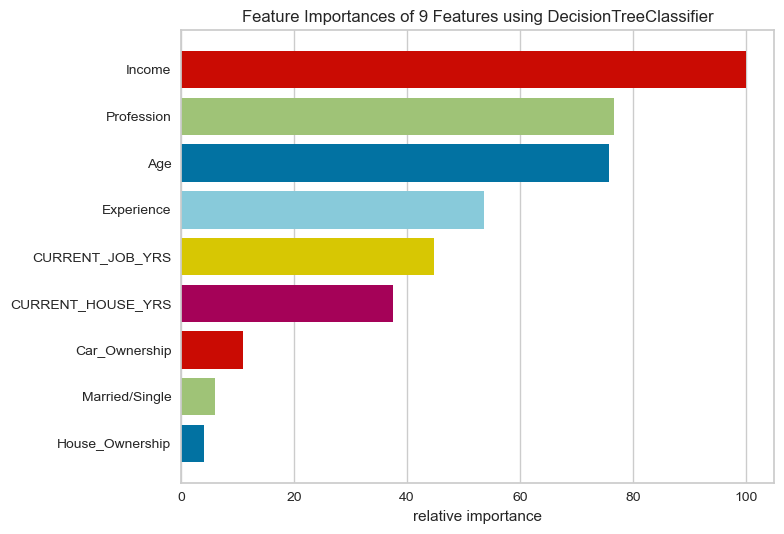

In [99]:
viz = FeatureImportances(clf, labels=X.columns)
viz.fit(X_train, y_train)
viz.show();

# Random Forest

In [100]:
# Random Forest (Bagging of multiple Decision Trees)
clf = RandomForestClassifier(max_depth=2, n_estimators=100,criterion='gini')

# Printing all the parameters of Random Forest
print(clf)

RandomForestClassifier(max_depth=2)


In [104]:
# Creating the model on resampled Training Data
RF=clf.fit(X_train_res, y_train_res)
y_pred = RF.predict(X_test)

In [105]:
# Measuring accuracy on Testing Data
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.90      0.32      0.47     66329
           1       0.13      0.75      0.23      9271

    accuracy                           0.37     75600
   macro avg       0.52      0.53      0.35     75600
weighted avg       0.81      0.37      0.44     75600



In [106]:
print('RF Test Score:',RF.score(X_test,y_test))

RF Test Score: 0.3712037037037037


## Confusion Matrix

In [107]:
cm = metrics.confusion_matrix(y_test, y_pred)
print(cm)

[[21107 45222]
 [ 2315  6956]]


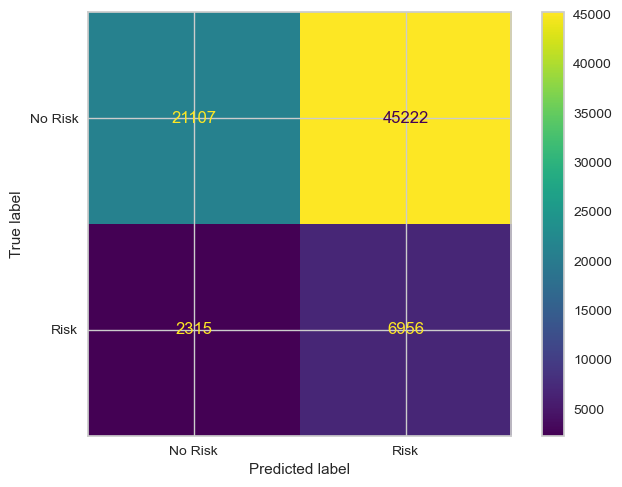

In [108]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classesMapped)
disp.plot()
plt.show()

In [256]:
# Running 10-Fold Cross validation on a given algorithm
# Passing full data X and y because the K-fold will split the data and automatically choose train/test
Accuracy_Values=cross_val_score(RF, X , y, cv=10, scoring='f1_weighted')
print('\nAccuracy values for 10-fold Cross Validation:\n',Accuracy_Values)
print('\nFinal Average Accuracy of the model:', round(Accuracy_Values.mean(),2))


Accuracy values for 10-fold Cross Validation:
 [0.8195642  0.8195642  0.8195642  0.8195642  0.81950737 0.81950737
 0.81950737 0.81950737 0.81950737 0.81950737]

Final Average Accuracy of the model: 0.82


## Plot Feature Importances

<AxesSubplot:title={'center':'Feature Importances'}>

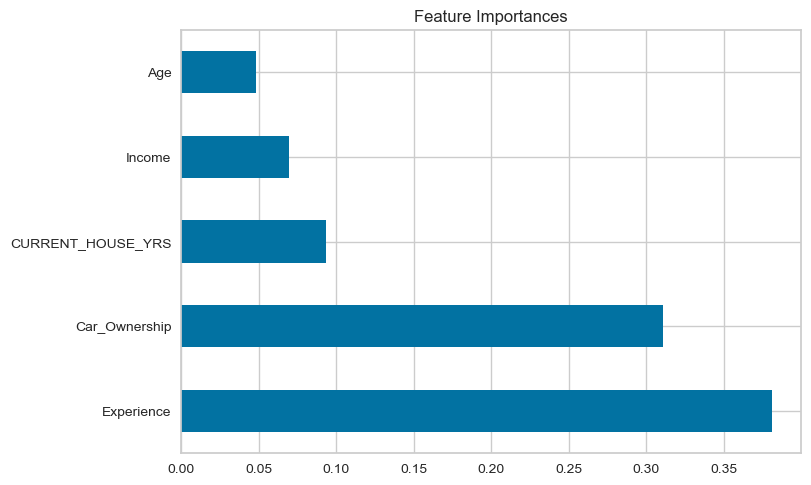

In [109]:
# Plotting the feature importance for Top 5 most important columns
feature_importances = pd.Series(RF.feature_importances_, index=Predictors)
feature_importances.nlargest().plot(kind='barh', title = 'Feature Importances', grid=True)

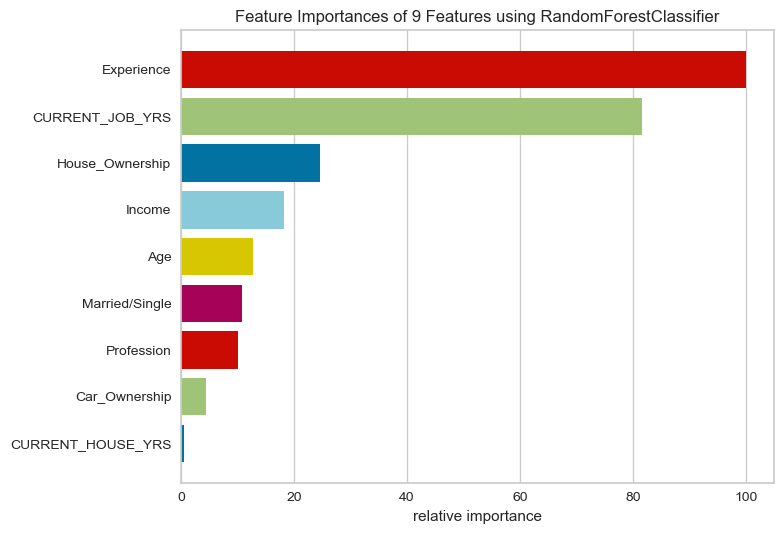

In [110]:
viz = FeatureImportances(clf, labels=X.columns)
viz.fit(X_train, y_train)
viz.show();

## Plotting one of the Decision Trees in the Random Forest

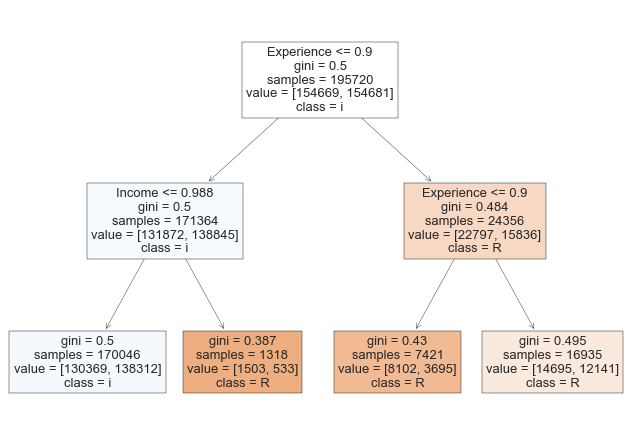

In [111]:
tree.plot_tree(clf.estimators_[4], filled=True,feature_names=Predictors, class_names=TargetVariable);

# AdaBoost

In [203]:
# Choosing Decision Tree with 1 level as the weak learner
DTC=DecisionTreeClassifier(max_depth=1)
clf = AdaBoostClassifier(n_estimators=500, base_estimator=DTC ,learning_rate=0.01)

# Printing all the parameters of Adaboost
print(clf)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.01, n_estimators=500)


In [204]:
# Creating the model on resampled Training Data
AB=clf.fit(X_train_res, y_train_res)
y_pred=AB.predict(X_test)

In [114]:
# Measuring accuracy on Testing Data
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.90      0.45      0.60     66329
           1       0.14      0.63      0.23      9271

    accuracy                           0.47     75600
   macro avg       0.52      0.54      0.41     75600
weighted avg       0.80      0.47      0.55     75600



In [115]:
print('AB Test Score:',AB.score(X_test,y_test))

AB Test Score: 0.47314814814814815


## Confusion Matrix

In [116]:
cm = metrics.confusion_matrix(y_test, y_pred)
print(cm)

[[29920 36409]
 [ 3421  5850]]


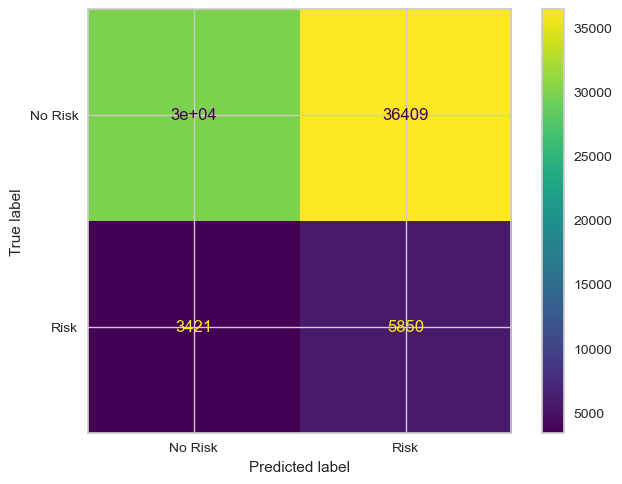

In [117]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classesMapped)

disp.plot()
plt.show()

In [205]:
# Running 10-Fold Cross validation on a given algorithm
# Passing full data X and y because the K-fold will split the data and automatically choose train/test
Accuracy_Values=cross_val_score(AB, X , y, cv=5, scoring='f1_weighted')
print('\nAccuracy values for 10-fold Cross Validation:\n',Accuracy_Values)
print('\nFinal Average Accuracy of the model:', round(Accuracy_Values.mean(),2))


Accuracy values for 10-fold Cross Validation:
 [0.81953579 0.81953579 0.81953579 0.81953579 0.81950737]

Final Average Accuracy of the model: 0.82


## Plot Feature Importances

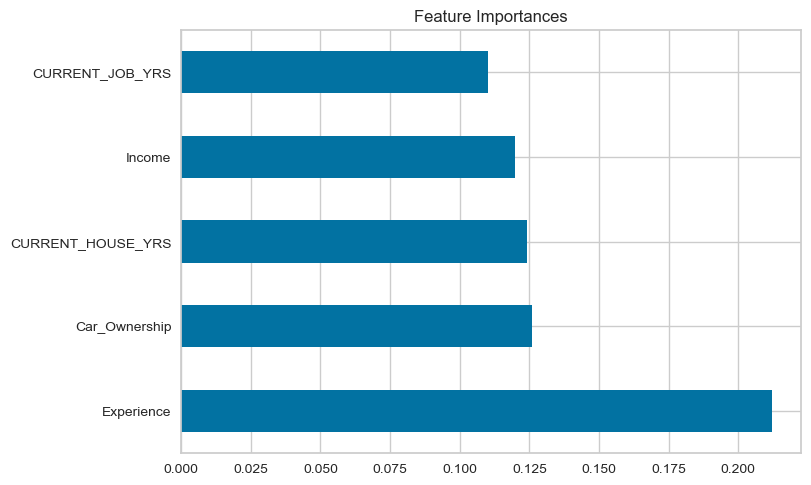

In [119]:
# Plotting the feature importance for Top 5 most important columns
feature_importances = pd.Series(AB.feature_importances_, index=Predictors)
feature_importances.nlargest().plot(kind='barh', title = 'Feature Importances', grid=True);

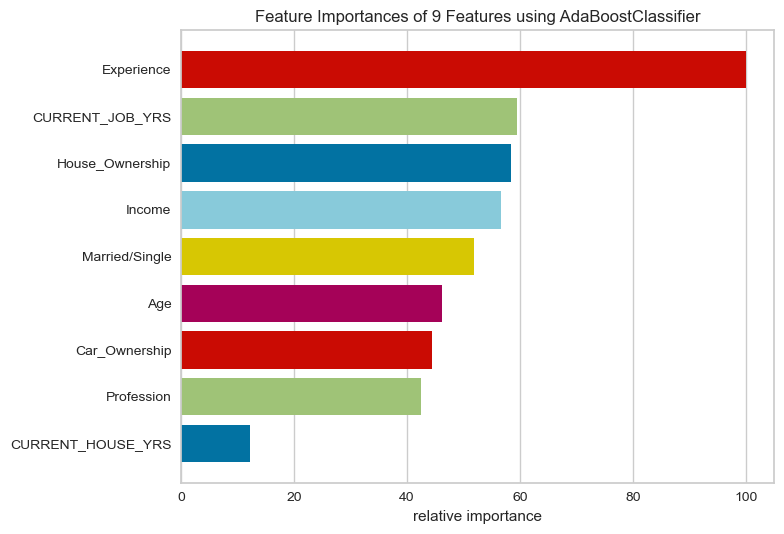

In [120]:
viz = FeatureImportances(clf, labels=X.columns)
viz.fit(X_train, y_train)
viz.show();

## Plot One Tree

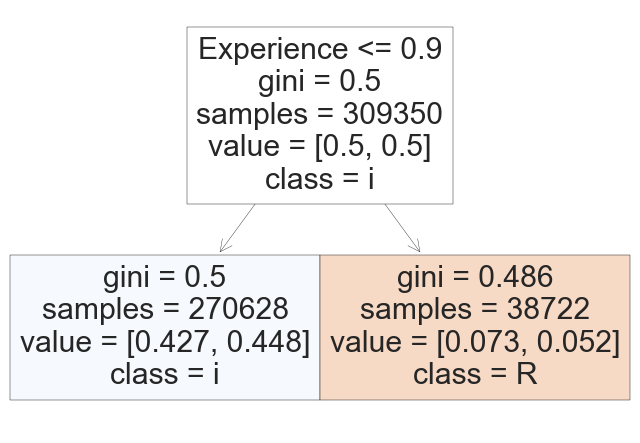

In [121]:
tree.plot_tree(clf.estimators_[5], filled=True,feature_names=Predictors, class_names=TargetVariable);

# KNN

In [206]:
# K-Nearest Neighbor(KNN)
clf = KNeighborsClassifier(n_neighbors=3)

# Printing all the parameters of KNN
print(clf)

KNeighborsClassifier(n_neighbors=3)


In [207]:
# Creating the model on resampled Training Data
KNN=clf.fit(X_train_res, y_train_res) 
y_pred=KNN.predict(X_test)

In [124]:
# Measuring accuracy on Testing Data
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.93      0.90      0.92     66329
           1       0.45      0.55      0.49      9271

    accuracy                           0.86     75600
   macro avg       0.69      0.73      0.71     75600
weighted avg       0.87      0.86      0.87     75600



In [125]:
print('KNN Test Score:',KNN.score(X_test,y_test))

KNN Test Score: 0.8607671957671957


## Confusion Matrix

In [128]:
cm = metrics.confusion_matrix(y_test, y_pred)
print(cm)

[[59987  6342]
 [ 4184  5087]]


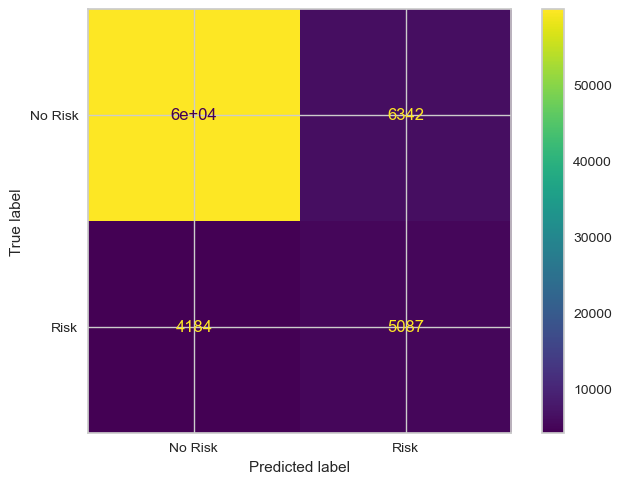

In [129]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classesMapped)

disp.plot()
plt.show()

In [208]:
# Running 10-Fold Cross validation on a given algorithm
# Passing full data X and y because the K-fold will split the data and automatically choose train/test
Accuracy_Values=cross_val_score(KNN, X , y, cv=5, scoring='f1_weighted')
print('\nAccuracy values for 10-fold Cross Validation:\n',Accuracy_Values)
print('\nFinal Average Accuracy of the model:', round(Accuracy_Values.mean(),2))


Accuracy values for 10-fold Cross Validation:
 [0.92996392 0.92450893 0.90984597 0.88377595 0.79019076]

Final Average Accuracy of the model: 0.89


In [ ]:
# 'KNeighborsClassifier' object has no attribute 'feature_importances_'

In [ ]:
# YellowbrickTypeError: could not find feature importances param on KNeighborsClassifier

# SVM

In [212]:
# Support Vector Machines(SVM)
clf = svm.SVC(C=3, kernel='rbf', gamma=0.1)

# Printing all the parameters of SVM
print(clf)

SVC(C=3, gamma=0.1)


In [ ]:
# # Creating the model on resampled Training Data
# SVM=clf.fit(X_train_res, y_train_res)
# y_pred=SVM.predict(X_test)

In [ ]:
# Measuring accuracy on Testing Data
print(classification_report(y_test,y_pred))

In [ ]:
print('SVM Test Score:',SVM.score(X_test,y_test))

## Confusion Matrix

In [ ]:
cm = metrics.confusion_matrix(y_test, y_pred)
print(cm)

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classesMapped)

disp.plot()
plt.show()

In [ ]:
# Running 10-Fold Cross validation on a given algorithm
# Passing full data X and y because the K-fold will split the data and automatically choose train/test
Accuracy_Values=cross_val_score(SVM, X , y, cv=5, scoring='f1_weighted')
print('\nAccuracy values for 10-fold Cross Validation:\n',Accuracy_Values)
print('\nFinal Average Accuracy of the model:', round(Accuracy_Values.mean(),2))

## Feature Importances

In [ ]:
# 'SVC' object has no attribute 'feature_importances_'

In [ ]:
# YellowbrickTypeError: could not find feature importances param on SVC

# Naive Bayes

In [151]:
# Naive Bayes
# GaussianNB is used in Binomial Classification
# MultinomialNB is used in multi-class classification
clf = GaussianNB()
#clf = MultinomialNB()

# Printing all the parameters of Naive Bayes
print(clf)

GaussianNB()


In [152]:
# Creating the model on resampled Training Data
NB=clf.fit(X_train_res, y_train_res)
y_pred=NB.predict(X_test)

In [153]:
# Measuring accuracy on Testing Data
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.25      0.40     66329
           1       0.13      0.81      0.23      9271

    accuracy                           0.32     75600
   macro avg       0.52      0.53      0.31     75600
weighted avg       0.81      0.32      0.38     75600



In [154]:
print('NB Test Score:',NB.score(X_test,y_test))

NB Test Score: 0.3226455026455026


## Confusion Matrix

In [155]:
cm = metrics.confusion_matrix(y_test, y_pred)
print(cm)

[[16912 49417]
 [ 1791  7480]]


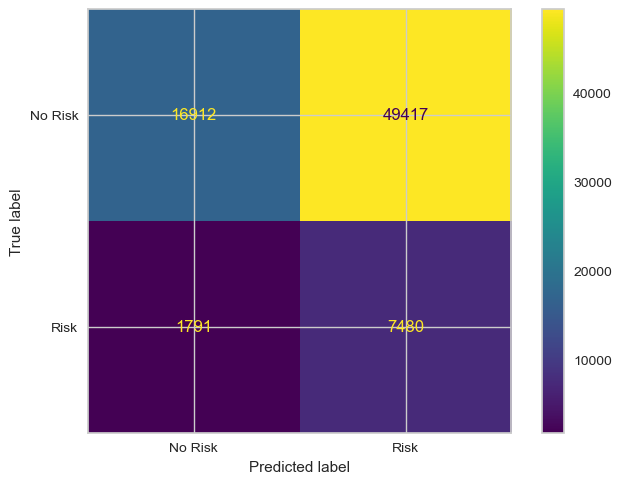

In [156]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classesMapped)

disp.plot()
plt.show()

In [157]:
# Running 10-Fold Cross validation on a given algorithm
# Passing full data X and y because the K-fold will split the data and automatically choose train/test
Accuracy_Values=cross_val_score(NB, X , y, cv=10, scoring='f1_weighted')
print('\nAccuracy values for 10-fold Cross Validation:\n',Accuracy_Values)
print('\nFinal Average Accuracy of the model:', round(Accuracy_Values.mean(),2))


Accuracy values for 10-fold Cross Validation:
 [0.8195642  0.8195642  0.8195642  0.8195642  0.81950737 0.81950737
 0.81950737 0.81950737 0.81950737 0.81950737]

Final Average Accuracy of the model: 0.82


## Feature Importances

In [ ]:
# 'GaussianNB' object has no attribute 'feature_importances_'

In [ ]:
# YellowbrickTypeError: could not find feature importances param on GaussianNB

# Passive Aggressive Classifier

In [209]:
clf = PassiveAggressiveClassifier(random_state=14500)

# Printing all the parameters of PAC
print(clf)

PassiveAggressiveClassifier(random_state=14500)


In [210]:
# Creating the model on resampled Training Data
PAC=clf.fit(X_train_res, y_train_res)
y_pred=PAC.predict(X_test)

In [211]:
# Measuring accuracy on Testing Data
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     66329
           1       0.12      1.00      0.22      9271

    accuracy                           0.12     75600
   macro avg       0.06      0.50      0.11     75600
weighted avg       0.02      0.12      0.03     75600



In [69]:
print('PAC Test Score:',PAC.score(X_test,y_test))

PAC Test Score: 0.12263227513227513


## Confusion Matrix

In [89]:
cm = metrics.confusion_matrix(y_test, y_pred)
print(cm)

[[  253 66076]
 [   26  9245]]


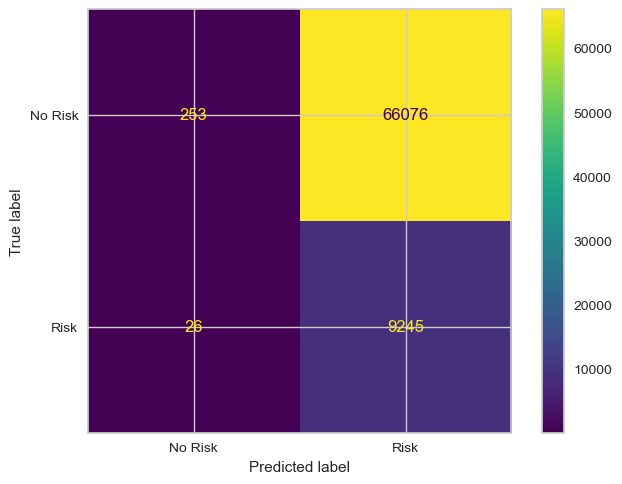

In [90]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classesMapped)

disp.plot()
plt.show()

In [91]:
# Running 10-Fold Cross validation on a given algorithm
# Passing full data X and y because the K-fold will split the data and automatically choose train/test
Accuracy_Values=cross_val_score(PAC, X , y, cv=10, scoring='f1_weighted')
print('\nAccuracy values for 10-fold Cross Validation:\n',Accuracy_Values)
print('\nFinal Average Accuracy of the model:', round(Accuracy_Values.mean(),2))


Accuracy values for 10-fold Cross Validation:
 [0.8195642  0.8195642  0.8195642  0.8195642  0.81950737 0.81950737
 0.81950737 0.81950737 0.81950737 0.03669111]

Final Average Accuracy of the model: 0.74


## Plot Feature Importance

In [92]:
# 'PassiveAggressiveClassifier' object has no attribute 'feature_importances_'

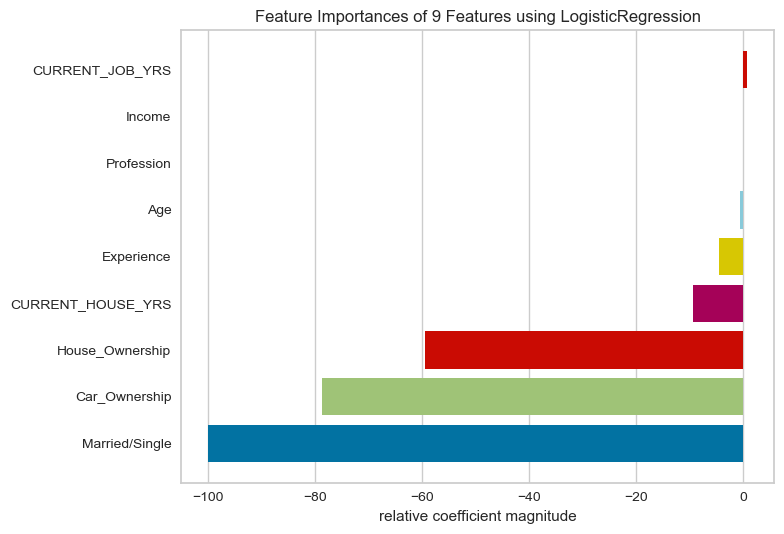

In [93]:
viz = FeatureImportances(clf, labels=X.columns)
viz.fit(X_train, y_train)
viz.show();

# Collect Model Data

In [141]:
models = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'AdaBoost',
         'KNN', 'SVM', 'Naive Bayes', 'Passive Aggressive Classifier']

scores = [0.505462, 0.870568, 0.371203, 0.473148, 0.860767, 0.00000, 0.322645, 0.7800] 

# Alogorithim Comparison

In [142]:
modelComparison = pd.DataFrame()

modelComparison['Test Score'] = scores
modelComparison.index = models
modelComparison

Test Score
Logistic Regression              0.505462
Decision Tree                    0.870568
Random Forest                    0.371203
AdaBoost                         0.473148
KNN                              0.860767
SVM                              0.000000
Naive Bayes                      0.322645
Passive Aggressive Classifier    0.780000

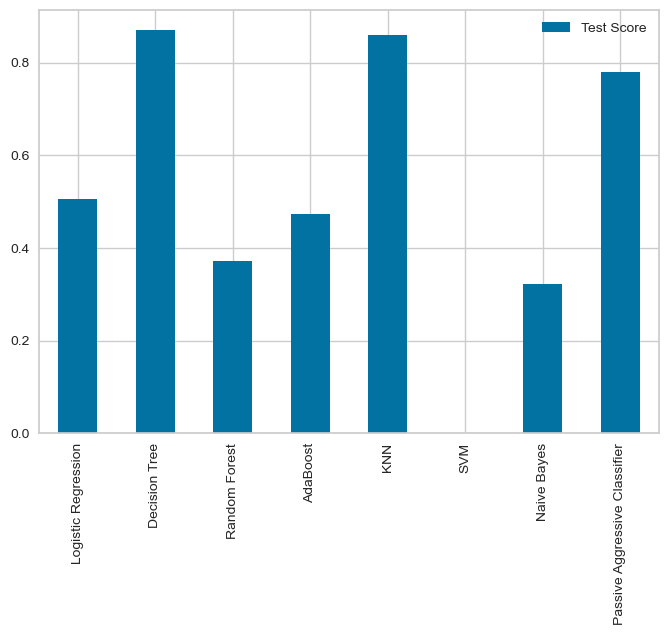

In [143]:
modelComparison.plot(kind='bar');